The goal is to detect whether the LSTM model trained on a dataset is able to capture the pattern and predict the values in a test dataset which has a different distribution from train set. A certain noise is added to the test set to make sure that it has a different distribution from the train set.

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [ ]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

# Hourly dataset
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [ ]:
# Distribution of the dataset
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


# Data Cleanup

In [ ]:
# Cleaning the data
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

# Feature engineering

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

timestamp_s = date_time.map(datetime.datetime.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))



# Splitting the data
We'll use a (70%, 20%, 10%) split for the training, validation, and test sets

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [ ]:
train_df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
count,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000,49063.00000,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000,49063.000000,4.906300e+04,4.906300e+04,49063.000000,49063.000000
mean,988.656343,9.108207,283.194958,4.599605,75.906008,13.355098,9.35696,3.998056,5.913550,9.466371,1216.994357,-0.594182,-0.391513,-0.962159,-0.709401,-5.430228e-05,-7.242153e-05,0.052824,-0.016243
std,8.297466,8.654950,8.724746,6.972275,16.555336,7.694738,4.20826,4.817741,2.671252,4.260055,40.957704,2.012931,1.561507,3.127322,2.619663,7.070906e-01,7.071373e-01,0.700623,0.711403
min,913.600000,-22.760000,250.850000,-24.800000,13.880000,0.970000,0.81000,0.000000,0.510000,0.810000,1059.450000,-11.305514,-8.274385,-19.641473,-14.883367,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000
25%,983.600000,2.990000,277.140000,-0.070000,65.010000,7.580000,6.08000,0.830000,3.840000,6.160000,1187.845000,-1.474871,-1.366222,-2.467895,-2.328903,-7.071068e-01,-7.071068e-01,-0.637769,-0.735192
50%,989.110000,9.190000,283.310000,4.960000,79.200000,11.640000,8.70000,2.150000,5.500000,8.810000,1213.780000,-0.626336,-0.275637,-1.107893,-0.497805,3.096025e-14,4.141627e-14,0.107106,-0.026703
75%,994.090000,15.340000,289.410000,9.850000,89.400000,17.460000,12.17000,5.290000,7.690000,12.300000,1243.380000,0.359578,0.480202,0.739683,0.867417,7.071068e-01,7.071068e-01,0.744637,0.696576
max,1012.830000,35.650000,309.730000,23.060000,100.000000,58.340000,28.25000,41.780000,18.070000,28.740000,1393.540000,8.244699,7.733831,11.913133,14.302308,1.000000e+00,1.000000e+00,1.000000,1.000000


# Adding noise to test dataset

In [ ]:
# generate a random number from a normal distribution
mu, sigma = 0, 0.3 
# creating a noise with the same dimension as the dataset
noise = np.random.normal(mu, sigma, test_df.shape)
# adding the noise to the dataset
noisy_test_df = test_df + noise

num_features = df.shape[1]
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
noisy_test_df = (noisy_test_df - train_mean) / train_std

In [ ]:
train_df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
count,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04
mean,9.868425e-13,3.447530e-15,2.422138e-13,-2.004796e-15,-5.014349e-15,-1.268746e-14,3.863838e-15,2.346661e-15,-1.450754e-14,8.046380e-15,-2.024757e-13,-3.155850e-15,-2.022203e-15,1.380910e-15,-1.414823e-15,-1.508870e-17,-2.669260e-17,2.060847e-16,-6.519276e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.045695e+00,-3.682079e+00,-3.707266e+00,-4.216645e+00,-3.746587e+00,-1.609554e+00,-2.030996e+00,-8.298612e-01,-2.022853e+00,-2.031986e+00,-3.846513e+00,-5.321263e+00,-5.048245e+00,-5.972942e+00,-5.410607e+00,-1.414169e+00,-1.414050e+00,-1.502697e+00,-1.382842e+00
25%,-6.093840e-01,-7.069026e-01,-6.939982e-01,-6.697392e-01,-6.581569e-01,-7.505257e-01,-7.786971e-01,-6.575813e-01,-7.762466e-01,-7.761335e-01,-7.116941e-01,-4.375161e-01,-6.242102e-01,-4.814777e-01,-6.182100e-01,-9.999460e-01,-9.998544e-01,-9.856843e-01,-1.010608e+00
50%,5.467421e-02,9.450477e-03,1.318575e-02,5.168967e-02,1.989686e-01,-2.228923e-01,-1.561120e-01,-3.835939e-01,-1.548152e-01,-1.540757e-01,-7.847992e-02,-1.597386e-02,7.420737e-02,-4.660022e-02,8.077215e-02,7.679677e-05,1.024151e-04,7.747715e-02,-1.470386e-02
75%,6.548575e-01,7.200265e-01,7.123465e-01,7.530390e-01,8.150841e-01,5.334687e-01,6.684569e-01,2.681639e-01,6.650251e-01,6.651626e-01,6.442168e-01,4.738166e-01,5.582518e-01,5.441849e-01,6.019162e-01,1.000100e+00,1.000059e+00,9.874267e-01,1.001990e+00
max,2.913378e+00,3.066661e+00,3.041354e+00,2.647686e+00,1.455361e+00,5.846190e+00,4.489514e+00,7.842254e+00,4.550843e+00,4.524268e+00,4.310438e+00,4.391051e+00,5.203526e+00,4.117034e+00,5.730397e+00,1.414323e+00,1.414255e+00,1.351906e+00,1.428505e+00


# Distribution of data

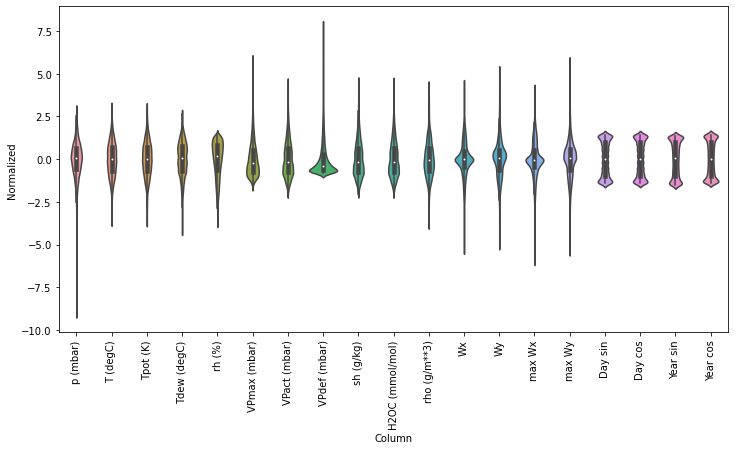

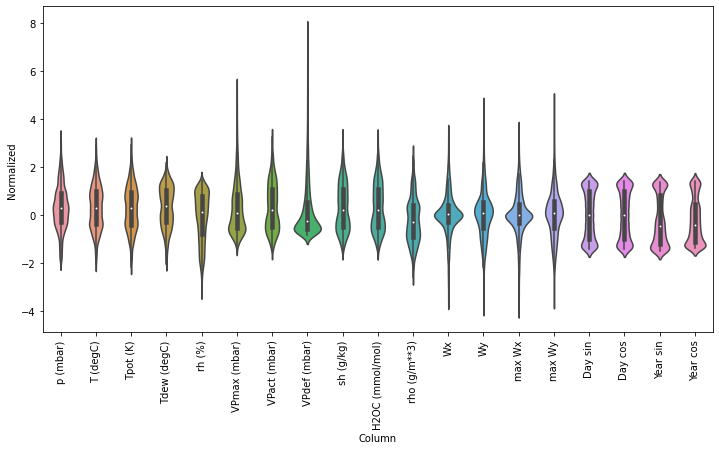

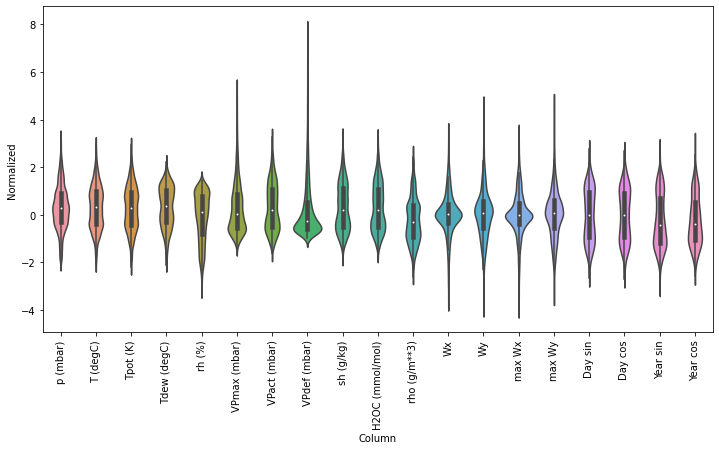

In [ ]:
df_std = train_df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(train_df.keys(), rotation=90)

df_std = test_df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(test_df.keys(), rotation=90)

df_std = noisy_test_df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(noisy_test_df.keys(), rotation=90)

# Helper Functions

In [ ]:
def split_data(df):
  column_indices = {name: i for i, name in enumerate(df.columns)}
  n = len(df)
  train_df = df[0:int(n*0.7)]
  val_df = df[int(n*0.7):int(n*0.9)]
  test_df = df[int(n*0.9):]
  return train_df, val_df, test_df

def add_noise(test_df, mu, sigma):
  # generate a random number from a normal distribution
  # creating a noise with the same dimension as the dataset
  noise = np.random.normal(mu, sigma, test_df.shape)
  # adding the noise to the dataset
  noisy_test_df = test_df + noise
  return noisy_test_df

def normalise_data(train_df, val_df, test_df, noisy_test_df):
  num_features = df.shape[1]
  train_mean = train_df.mean()
  train_std = train_df.std()

  train_df = (train_df - train_mean) / train_std
  val_df = (val_df - train_mean) / train_std
  test_df = (test_df - train_mean) / train_std
  noisy_test_df = (noisy_test_df - train_mean) / train_std
  return train_df, val_df, test_df, noisy_test_df

def train_ss_so_model(wide_window):
  num_features = wide_window.train_df.shape[1]
  ss_so_model = tf.keras.models.Sequential([
      # Shape [batch, time, features] => [batch, time, lstm_units]
      tf.keras.layers.LSTM(32, return_sequences=True),
      # Shape => [batch, time, features]
      tf.keras.layers.Dense(units=1)
  ])
  print('Input shape:', wide_window.example[0].shape)
  print('Output shape:', ss_so_model(wide_window.example[0]).shape)
  ss_so_model_history = compile_and_fit(ss_so_model, wide_window)
  return ss_so_model

def train_ss_mo_model(wide_window):
  # predict multiple features, predict 1hr into the future gien 24hr of the past
  %%time
  num_features = wide_window.train_df.shape[1]
  ss_mo_model = tf.keras.models.Sequential([
      # Shape [batch, time, features] => [batch, time, lstm_units]
      tf.keras.layers.LSTM(32, return_sequences=True),
      # Shape => [batch, time, features]
      tf.keras.layers.Dense(units=num_features)
  ])

  ss_mo_model_history = compile_and_fit(ss_mo_model, wide_window)
  return ss_mo_model

def train_ms_ss_so_model(multi_window):
  # predict 24h into the future, given 24hr of the past single output
  OUT_STEPS = 24
  num_features = multi_window.train_df.shape[1]
  # One high level approach to this problem is use a "single-shot" model, where the model makes the entire sequence prediction in a single step.
  ms_ss_so_model = tf.keras.Sequential([
      # Shape [batch, time, features] => [batch, lstm_units]
      # Adding more `lstm_units` just overfits more quickly.
      tf.keras.layers.LSTM(32, return_sequences=False),
      # Shape => [batch, out_steps*features]
      tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros),
      # Shape => [batch, out_steps, features]
      tf.keras.layers.Reshape([OUT_STEPS, num_features])
  ])

  ms_ss_so_model_history = compile_and_fit(ms_ss_so_model, multi_window)
  return ms_ss_so_model

def train_ms_ss_mo_model(multi_window):
  # predict 24h into the future, given 24hr of the past multiple outputs
  OUT_STEPS = 24
  num_features = multi_window.train_df.shape[1]
  ms_ss_mo_model = tf.keras.Sequential([
      # Shape [batch, time, features] => [batch, lstm_units]
      # Adding more `lstm_units` just overfits more quickly.
      tf.keras.layers.LSTM(32, return_sequences=False),
      # Shape => [batch, out_steps*features]
      tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros),
      # Shape => [batch, out_steps, features]
      tf.keras.layers.Reshape([OUT_STEPS, num_features])
  ])

  ms_ss_mo_model_history = compile_and_fit(ms_ss_mo_model, multi_window)
  return ms_ss_mo_model
  

# Performance Plot

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
noisy_mae = [v[metric_index] for v in noisy_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, test_mae, width, label='Test')
plt.bar(x + 0.17, noisy_mae, width, label='Noisy')

plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

In [ ]:
for name, value in noisy_performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

# Execution

In [ ]:
train_df, val_df, test_df = split_data(df)
mu, sigma = 0, 0.5
noisy_test_df = add_noise(test_df, mu, sigma)
train_df, val_df, test_df, noisy_test_df = normalise_data(train_df, val_df, test_df, noisy_test_df)

MAX_EPOCHS = 20

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df, 
               noisy_test_df=noisy_test_df, label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.noisy_test_df = noisy_test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels


def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def noisy_test(self):
  return self.make_dataset(noisy_test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result


def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

WindowGenerator.split_window = split_window
WindowGenerator.plot = plot
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.noisy_test = noisy_test
WindowGenerator.example = example

In [ ]:
val_performance = {}
performance = {}
noisy_performance = {}

# Perdict only one target variable (Temperature)
ss_so_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

# Single step single output model
ss_so_model = train_ss_so_model(ss_so_window)
val_performance['ss_so'] = ss_so_model.evaluate(ss_so_window.val)
performance['ss_so'] = ss_so_model.evaluate(ss_so_window.test, verbose=0)
noisy_performance['ss_so'] = ss_so_model.evaluate(ss_so_window.noisy_test, verbose=0)

# Plotting the error as distribution

In [ ]:
predictions = []
actual = []
for i in ss_so_window.test:
  pred = ss_so_model(i[0])
  for j in pred:
    predictions.append(j[1].numpy()[0])
  for k in i[1]:
    actual.append(k[1].numpy()[0])

error_array = np.array(actual) - np.array(predictions)
n, bins, patches = plt.hist(error_array)
print('Mean:{} Variance: {}'.format(error_array.mean(), error_array.var()))
plt.show()

NameError: ignored

In [ ]:
# Test
error_array

In [ ]:
ss_mo_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

# Single step multiple output model
ss_mo_model = train_ss_mo_model(ss_mo_window)
val_performance['ss_mo'] = ss_mo_model.evaluate( ss_mo_window.val)
performance['ss_mo'] = ss_mo_model.evaluate( ss_mo_window.test, verbose=0)
noisy_performance['ss_mo'] = ss_mo_model.evaluate( ss_mo_window.noisy_test, verbose=0)

In [ ]:
# predict 24h into the future, given 24hr of the past single output
OUT_STEPS = 24
ms_ss_so_multi_window = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=['T (degC)'])

# Multi step single output model
ms_ss_so_model = train_ms_ss_so_model(ms_ss_so_multi_window)
val_performance['ms_ss_so'] = ms_ss_so_model.evaluate(ms_ss_so_multi_window.val)
performance['ms_ss_so'] = ms_ss_so_model.evaluate(ms_ss_so_multi_window.test, verbose=0)
noisy_performance['ms_ss_so'] = ms_ss_so_model.evaluate(ms_ss_so_multi_window.noisy_test, verbose=0)

In [ ]:
# predict 24h into the future, given 24hr of the past multiple outputs
OUT_STEPS = 24
ms_ss_mo_multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

# Multi step multi output model
ms_ss_mo_model = train_ms_ss_mo_model(ms_ss_mo_multi_window)
val_performance['ms_ss_mo'] = ms_ss_mo_model.evaluate(ms_ss_mo_multi_window.val)
performance['ms_ss_mo'] = ms_ss_mo_model.evaluate(ms_ss_mo_multi_window.test, verbose=0)
noisy_performance['ms_ss_mo'] = ms_ss_mo_model.evaluate(ms_ss_mo_multi_window.noisy_test, verbose=0)

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = ms_ss_mo_model.metrics_names.index('mean_absolute_error')
noisy_mae = [v[metric_index] for v in noisy_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, test_mae, width, label='Test')
plt.bar(x + 0.17, noisy_mae, width, label='Noisy')

plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

for name, value in noisy_performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

In [ ]:
train_df, val_df, test_df = split_data(df)
mu, sigma = 0, 1.5
noisy_test_df = add_noise(test_df, mu, sigma)
train_df, val_df, test_df, noisy_test_df = normalise_data(train_df, val_df, test_df, noisy_test_df)

MAX_EPOCHS = 20

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df, 
               noisy_test_df=noisy_test_df, label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.noisy_test_df = noisy_test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels


def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def noisy_test(self):
  return self.make_dataset(noisy_test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result


def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

WindowGenerator.split_window = split_window
WindowGenerator.plot = plot
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.noisy_test = noisy_test
WindowGenerator.example = example

val_performance['ss_so'] = ss_so_model.evaluate(ss_so_window.val)
performance['ss_so'] = ss_so_model.evaluate(ss_so_window.test, verbose=0)
noisy_performance['ss_so'] = ss_so_model.evaluate(ss_so_window.noisy_test, verbose=0)

val_performance['ss_mo'] = ss_mo_model.evaluate( ss_mo_window.val)
performance['ss_mo'] = ss_mo_model.evaluate( ss_mo_window.test, verbose=0)
noisy_performance['ss_mo'] = ss_mo_model.evaluate( ss_mo_window.noisy_test, verbose=0)

val_performance['ms_ss_so'] = ms_ss_so_model.evaluate(ms_ss_so_multi_window.val)
performance['ms_ss_so'] = ms_ss_so_model.evaluate(ms_ss_so_multi_window.test, verbose=0)
noisy_performance['ms_ss_so'] = ms_ss_so_model.evaluate(ms_ss_so_multi_window.noisy_test, verbose=0)

val_performance['ms_ss_mo'] = ms_ss_mo_model.evaluate(ms_ss_mo_multi_window.val)
performance['ms_ss_mo'] = ms_ss_mo_model.evaluate(ms_ss_mo_multi_window.test, verbose=0)
noisy_performance['ms_ss_mo'] = ms_ss_mo_model.evaluate(ms_ss_mo_multi_window.noisy_test, verbose=0)

x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = ms_ss_mo_model.metrics_names.index('mean_absolute_error')
noisy_mae = [v[metric_index] for v in noisy_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, test_mae, width, label='Test')
plt.bar(x + 0.17, noisy_mae, width, label='Noisy')

plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

for name, value in noisy_performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')